# Simple MNIST NN from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('train.csv')

In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [3]:
Y_train

array([9, 4, 1, ..., 2, 3, 6], dtype=int64)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [4]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [6]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[9 9 9 ... 9 9 1] [9 4 1 ... 2 3 6]
0.10736585365853658
Iteration:  10
[4 9 8 ... 9 0 6] [9 4 1 ... 2 3 6]
0.18334146341463414
Iteration:  20
[7 9 7 ... 9 1 6] [9 4 1 ... 2 3 6]
0.26153658536585367
Iteration:  30
[7 9 7 ... 9 1 6] [9 4 1 ... 2 3 6]
0.3200487804878049
Iteration:  40
[7 9 7 ... 6 1 6] [9 4 1 ... 2 3 6]
0.38034146341463415
Iteration:  50
[7 9 1 ... 6 1 6] [9 4 1 ... 2 3 6]
0.436
Iteration:  60
[7 9 1 ... 6 1 6] [9 4 1 ... 2 3 6]
0.4890731707317073
Iteration:  70
[7 9 1 ... 6 1 6] [9 4 1 ... 2 3 6]
0.5367560975609756
Iteration:  80
[9 9 1 ... 6 1 6] [9 4 1 ... 2 3 6]
0.5781463414634146
Iteration:  90
[9 9 1 ... 6 1 6] [9 4 1 ... 2 3 6]
0.6101951219512195
Iteration:  100
[9 9 1 ... 6 1 6] [9 4 1 ... 2 3 6]
0.6367560975609756
Iteration:  110
[9 9 1 ... 6 1 4] [9 4 1 ... 2 3 6]
0.6582439024390244
Iteration:  120
[9 9 1 ... 6 1 4] [9 4 1 ... 2 3 6]
0.6767317073170732
Iteration:  130
[9 9 1 ... 2 1 4] [9 4 1 ... 2 3 6]
0.6926585365853658
Iteration:  140
[9 9 1 ...

~85% accuracy on training set.

In [7]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [9]
Label:  9


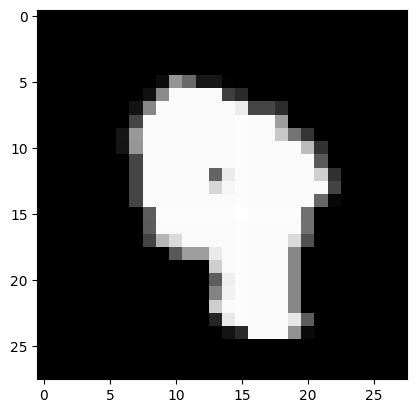

Prediction:  [9]
Label:  4


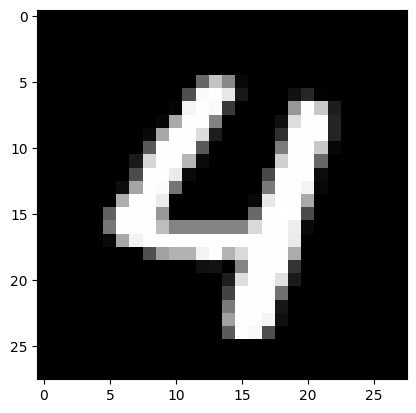

Prediction:  [1]
Label:  1


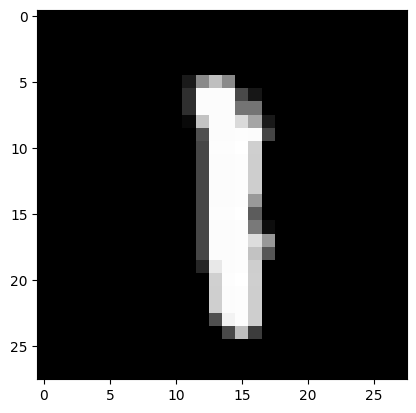

Prediction:  [2]
Label:  2


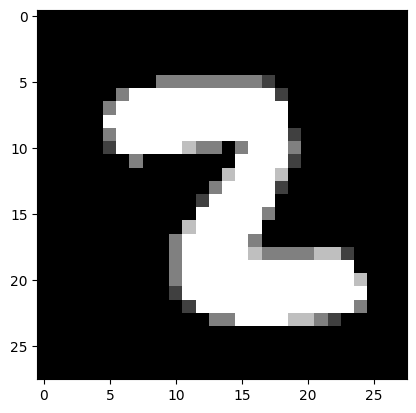

In [8]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [9]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[9 9 5 0 1 6 0 3 1 9 7 7 8 8 0 9 2 2 6 1 4 7 8 8 2 5 8 9 9 4 4 1 2 1 6 0 7
 4 1 5 1 4 3 0 6 4 6 5 1 0 9 4 9 1 4 2 9 5 3 0 0 4 1 5 2 4 0 2 2 4 0 9 0 4
 0 8 5 2 3 8 6 4 2 9 9 4 5 5 2 3 4 4 5 2 3 5 8 3 9 5 4 3 9 6 7 9 5 2 8 8 2
 8 9 3 8 6 2 9 5 6 7 7 7 7 8 4 5 0 0 1 8 0 3 2 0 7 4 4 8 0 3 8 2 7 3 1 1 8
 2 9 6 5 9 3 0 3 4 0 8 0 9 2 6 5 1 3 2 7 5 6 3 6 9 5 4 1 1 4 3 8 2 4 6 1 1
 6 0 6 0 2 3 0 5 8 3 6 1 2 0 5 4 4 2 3 3 0 6 1 4 8 3 8 1 2 0 2 5 2 9 1 3 9
 0 5 5 2 6 3 4 0 4 2 6 5 7 9 5 2 1 4 5 8 8 1 0 5 2 4 8 0 2 4 5 2 0 7 3 5 2
 5 6 1 9 0 8 3 6 2 9 3 8 7 4 0 0 4 1 1 2 0 3 4 5 1 4 5 4 0 2 0 3 3 4 8 6 7
 6 0 4 5 0 1 3 1 8 1 9 6 3 6 4 0 4 9 1 2 0 6 7 2 0 6 2 3 5 3 0 1 2 2 2 7 2
 6 2 0 5 7 1 8 9 2 2 3 9 5 2 4 2 2 4 3 7 0 8 4 1 0 8 9 6 9 8 2 0 4 8 5 1 1
 4 7 6 3 3 4 8 0 0 5 4 3 6 3 6 5 9 3 4 0 9 4 8 5 4 1 6 0 8 9 0 3 1 5 1 0 9
 3 9 7 8 4 2 4 7 5 1 9 2 1 1 7 4 9 5 0 6 3 6 8 4 1 1 6 4 7 6 3 7 2 9 5 0 3
 6 2 1 6 8 9 9 6 6 6 3 6 9 1 4 5 8 6 9 7 9 2 8 2 2 8 1 2 8 7 7 2 4 0 5 1 0
 2 5 0 3 0 4 6 3 7 1 0 6 

0.822

Still 84% accuracy, so our model generalized from the training data pretty well.